<a href="https://colab.research.google.com/github/hailuu684/Convolution-net/blob/main/Train_on_1_side(front).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
print(np.__version__)
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import csv

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda

1.19.5
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


# Preprocess hungarian

In [2]:
def replacenan(t):
    return tf.where(tf.math.is_nan(t), x = tf.zeros_like(t), y = t)

def replace_nan_by_10_square_10(t):
    return tf.where(tf.math.is_nan(t), x = 10**10, y = t)

def replace_nan_by_1000(t):
    return tf.where(tf.math.is_nan(t), x = tf.cast(1000,dtype=tf.float32), y = t)

def replace_10_square_10_by_zero(t):
    return tf.where(tf.math.equal(t, 10**10), x = 0.0, y = t)

def replace_zero_by_two(t):
    return tf.where(tf.math.equal(t, 0), x = 2.0, y = t)

def replace_two_by_zero(t):
    return tf.where(tf.math.equal(t, 2), x = 0.0, y = t)

def remove_zero(t):
    intermediate_tensor = t
    # intermediate_tensor = tf.cast(intermediate_tensor,tf.double)
    batch = t.shape[0]
    zero_vector = tf.zeros(shape=t.shape, dtype=tf.double)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    omit_zeros = tf.boolean_mask(intermediate_tensor, bool_mask)
    # tf.print('omit zero',omit_zeros)

    non_zero_dimension = int(len(omit_zeros) / batch)


    omit_zeros = tf.reshape(omit_zeros,shape=(batch,non_zero_dimension))
    return omit_zeros

# y_true and y_pred test data

In [ ]:
y_true_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)
y_pred_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)

y_true_test_h_l = np.array(y_true_test_h_l)
y_pred_test_h_l = np.array(y_pred_test_h_l)

y_true_test_h_l[:,8:] = np.nan
# y_pred_test_h_l[:,8:] = np.nan

y_true_test_h_l[:,11] = 0
y_true_test_h_l[:,15] = 0
y_true_test_h_l[:,19] = 0
y_true_test_h_l[:,23] = 0
y_true_test_h_l[:,27] = 0

y_pred_test_h_l[:,11] = 0
y_pred_test_h_l[:,15] = 0
y_pred_test_h_l[:,19] = 0
y_pred_test_h_l[:,23] = 0
y_pred_test_h_l[:,27] = 0

# Test 0 like 0 in relative coordinate
# y_true_test_h_l[:,2][0] = 0.5
# y_true_test_h_l[:,0][0] = 0



for i in range(len(y_true_test_h_l[:,3])):
    y_true_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])

    y_true_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])

    # confident values
    y_true_test_h_l[:,3][i] = 1.0
    y_pred_test_h_l[:,3][i] = 1.0
    y_true_test_h_l[:,7][i] = 1.0
    y_pred_test_h_l[:,7][i] = 1.0

y_true_test_h_l[1,8] = 2.342432
y_true_test_h_l[1,9] = 1.534534
y_true_test_h_l[1,10] = 0
y_true_test_h_l[1,11] = 1.0

y_pred_test_h_l[1,8] = 1.3432
y_pred_test_h_l[1,9] = 1.7453
y_pred_test_h_l[1,10] = 0.2
y_pred_test_h_l[1,11] = 0.9

y_true_test_h_l = tf.convert_to_tensor(y_true_test_h_l)
y_pred_test_h_l = tf.convert_to_tensor(y_pred_test_h_l)

# Hungarian loss

In [3]:

reduce_mean_cls_loss_store = []
regression_loss_store = []
reduce_confident_loss_store = []
# global store_hungarian_row_col
def hungarian_loss_fixed(y_true, y_pred): # -----> worked with non-nan values, the trick here is you should not use for loop 
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]


    # Replace 0( relative_coordinate) --> 2
    y_true_ = replace_zero_by_two(y_true_)
    y_pred_ = replace_zero_by_two(y_pred_)


    # if change nan --> 10^10
    y_true_ = replace_nan_by_10_square_10(y_true_) # shape = (16,7,2)
    y_pred_ = replace_nan_by_10_square_10(y_pred_)


    # Replace 2 --> 0 of relative coordinate of y_true
    y_true_ = replace_two_by_zero(y_true_) # shape = (16,7,2)
    y_pred_ = replace_two_by_zero(y_pred_)


    y_true_test = y_true_
    y_pred_test = y_pred_

    # tf.print(y_true_.shape)
    y_true_ = tf.cast(y_true_,dtype=tf.double)
    y_pred_ = tf.cast(y_pred_,dtype=tf.double)


    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_pred_[:,i,:2] - y_true_[:,j,:2]),dtype=tf.double),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) ))
    # print(cost_reshape.shape) # shape = (16,7,7)

    final_cost = []
    pair_row_col = []

    y_true_cls_conf = y_true_reshape[:,:,2:4] 
    y_pred_cls_conf = tf.sigmoid(y_pred_reshape[:,:,2:4])

    # store_hungarian_row_col = []
    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())
        # print(row_ind,col_ind)
        for row,col in zip(row_ind,col_ind): 
            if cost_reshape[i,row,col] < 10**10:
                final_cost.append(cost_reshape[i,row,col])  

        pair_row_col.append(chosen_elements)


    final_cost = tf.convert_to_tensor(final_cost) 
    # print('final cost shape',final_cost.shape) # shape = ( 112,) = (16,7)
    

    cost = tf.cast(final_cost,dtype=tf.float32)
    #-----------------------------
    #--------Hungarian loss-------
    #-----------------------------

    final_cost = tf.reduce_mean(final_cost) # shape = ()
    # tf.print('\nDone hungarian loss part')
    #----------------
    #---class loss--- note that 16 is the batch
    #----------------
    # print(y_true_reshape)

    y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
    
    # Confident scores
    y_true_conf = y_true_reshape[:,:,3] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_conf = tf.sigmoid(y_pred_reshape[:,:,3])

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    y_true_cls_tf = []
    y_pred_cls_tf = []
    cls_loss = []
    store_confident_loss = []

    y_true_stack_pair = []
    y_pred_stack_pair = []

    for i,batch_pair in enumerate(pair_row_col):
        for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
            # tf.print(row,col)
            
            y_true_paired = y_true_cls_conf[i,row,:]
            y_pred_paired = y_pred_cls_conf[i,col,:]


            y_true_stack_pair.append(y_true_paired)
            y_pred_stack_pair.append(y_pred_paired)    
            
    batch_size_stack_pair = int(len(y_true_stack_pair) / 7)
    # tf.print(batch_size_stack_pair)
    y_true_stack_pair = tf.reshape(y_true_stack_pair,shape=(batch_size_stack_pair,7,2))
    y_pred_stack_pair = tf.reshape(y_pred_stack_pair,shape=(batch_size_stack_pair,7,2))

    for i in range(len(y_true_stack_pair)):
        num_true_object = np.count_nonzero(~np.isnan(np.array(y_true_stack_pair[i,:,0])))

        y_true_cls_true_obj = y_true_stack_pair[i,:num_true_object,0]
        y_pred_cls_true_obj = y_pred_stack_pair[i,:num_true_object,0]

        y_true_conf_true_obj = y_true_stack_pair[i,:num_true_object,1]
        y_pred_conf_true_obj = y_pred_stack_pair[i,:num_true_object,1]

        # y_true_true_obj = y_true_stack_pair[i,:num_true_object,:]
        # y_pred_true_obj = y_pred_stack_pair[i,:num_true_object,:]

        # # get the cls and confident scores if confident scores > 0.5
        # y_true_true_obj_filtered = y_true_true_obj[y_pred_true_obj[:,1]>0.5]
        # y_pred_true_obj_filtered = y_pred_true_obj[y_pred_true_obj[:,1]>0.5]

        cls_bce_loss = bce(y_true_cls_true_obj, y_pred_cls_true_obj)
        cls_loss.append(cls_bce_loss)

        confident_loss = bce(y_true_conf_true_obj, y_pred_conf_true_obj)
        store_confident_loss.append(confident_loss)



    reduce_mean_cls_loss = tf.reduce_mean(cls_loss)
    # tf.print('\nDone class loss part')
    #------------------------
    #-----Confident Loss-----
    #------------------------
    reduce_confident_loss = tf.reduce_mean(store_confident_loss)
    # print('confident loss', store_confident_loss)

    #----------------------------
    #------ SUM OF LOSSES--------
    #----------------------------
    regression_loss = final_cost

    # Training
    regression_loss = tf.cast(regression_loss,dtype=tf.float32)

    # Testing
    # regression_loss = tf.cast(regression_loss,dtype=tf.double)

    # tf.print('\nreduce_confident_loss = ', reduce_confident_loss)
    # tf.print('\nreduce_mean_cls_loss = ', reduce_mean_cls_loss)
    # tf.print('\nregression loss = ', regression_loss)
    sum_loss = reduce_mean_cls_loss + regression_loss + reduce_confident_loss

    reduce_mean_cls_loss_store.append(reduce_mean_cls_loss)
    regression_loss_store.append(regression_loss)
    reduce_confident_loss_store.append(reduce_confident_loss)
    return sum_loss

# Use with model.fit() 
def hungarian_loss_fit_fixed(y_true, y_pred):
    loss = tf.py_function(func=hungarian_loss_fixed, inp=[y_true,y_pred], Tout=tf.float32,)
    loss_tensor = tf.convert_to_tensor(loss)
    # print('hungarian loss shape',cost_tensor.shape)

    return loss_tensor

# Get hungarian col and row

In [4]:

def get_hungarian_row_col(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]

    y_true_ = tf.cast(y_true_,dtype=tf.float32)
    y_pred_ = tf.cast(y_pred_,dtype=tf.float32)

    # Replace 0( relative_coordinate) --> 2
    y_true_ = replace_zero_by_two(y_true_)
    y_pred_ = replace_zero_by_two(y_pred_)


    # if change nan --> 10^10
    y_true_ = replace_nan_by_1000(y_true_) # shape = (16,7,2)
    y_pred_ = replace_nan_by_1000(y_pred_)


    # Replace 2 --> 0 of relative coordinate of y_true
    y_true_ = replace_two_by_zero(y_true_) # shape = (16,7,2)
    y_pred_ = replace_two_by_zero(y_pred_)


    y_true_test = y_true_
    y_pred_test = y_pred_


    # tf.print(y_true_.shape)
    

    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_pred_[:,i,:2] - y_true_[:,j,:2]),dtype=tf.float32),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) ))
    # print(cost_reshape.shape) # shape = (16,7,7)
    # print(cost_reshape)

    pair_row_col = []

    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())   
        pair_row_col.append(chosen_elements)
    return pair_row_col


# Custom mse metric using hungarian algorithm

In [5]:
import tensorflow.keras.backend as K
def custom_mse_hungarian(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    # Get indices from hungarian algorithm
    pair_row_col = get_hungarian_row_col(y_true, y_pred)
    
    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)
    
    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))
    
    store_loss = []
    for i,batch_pair in enumerate(pair_row_col):
        for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
            # tf.print(row,col)
            if y_pred_reshape[i,col,3] > 0.5:
                loss = K.square(y_true_reshape[i,row,:2] - y_pred_reshape[i,col,:2])  
                loss = tf.reduce_mean(loss)

                # Need some modify here y_true_reshape[i,row,:2] shape = (1,1,2) --> not correct, or not, need to test again

                if not tf.math.is_nan(loss):
                    store_loss.append(loss)
                else:
                    pass
            else:
                pass

    loss = tf.reduce_mean(store_loss)
    loss = tf.cast(loss,dtype=tf.float32)

    return loss

def custom_mse_hungarian_py_func(y_true, y_pred):
    loss = tf.py_function(func=custom_mse_hungarian, inp=[y_true,y_pred], Tout=tf.float32,name='custom_mse')
    loss_tensor = tf.convert_to_tensor(loss)
    # print('hungarian loss shape',cost_tensor.shape)

    return loss_tensor

# Precision and recall at callback

In [6]:
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.callbacks import Callback

save_precision_05 = []
save_precision_075 = []
save_recall_05 = []
save_recall_075 = []

class Evaluation_callback(Callback):
    def __init__(self, validation_data, interval=1):
        super(Evaluation_callback, self).__init__()

        self.interval = interval
        self.y_val = np.concatenate([y for x, y in validation_data], axis=0)
        self.X_val = np.concatenate([x for x, y in validation_data], axis=0)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            
            y_pred = self.model.predict(self.X_val, verbose=0)
            
            batch_size = tf.shape(self.y_val)[0]
            y_h = int(self.y_val.shape[1]//4)

            y_true_reshape = tf.reshape(self.y_val,shape=(batch_size,y_h,4))
            y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

            # Get class   
            y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
            y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])

            # Get class and confident scores  
            y_true_cls_conf = y_true_reshape[:,:,2:4] 
            y_pred_cls_conf = tf.sigmoid(y_pred_reshape[:,:,2:4])

            store_precision_skl = []
            store_recall_skl = []

            # Get indices from hungarian algorithm
            pair_row_col = get_hungarian_row_col(self.y_val, y_pred)

            y_true_stack_pair = []
            y_pred_stack_pair = []

            # recall from tensorflow
            recall_tf = tf.keras.metrics.Recall()   
            # precision from tensorflow
            precision_tf = tf.keras.metrics.Precision()
            
            # Self implemented precision and recall
            false_negative = 0
            true_positive = 0
            false_positive = 0
            self_imp_recall_store = []
            self_imp_precision_store = []

            for i,batch_pair in enumerate(pair_row_col):
                for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
                    # tf.print(row,col)
                    
                    y_true_paired = y_true_cls_conf[i,row,:]
                    y_pred_paired = y_pred_cls_conf[i,col,:]

                    # print('y-true-paired',y_true_paired)
                    # print('y-pred-paired',y_pred_paired)

                    y_true_stack_pair.append(y_true_paired)
                    y_pred_stack_pair.append(y_pred_paired)
            
            batch_size_stack_pair = int(len(y_true_stack_pair) / 7)
            # tf.print(batch_size_stack_pair)
            y_true_stack_pair = tf.reshape(y_true_stack_pair,shape=(batch_size_stack_pair,7,2))
            y_pred_stack_pair = tf.reshape(y_pred_stack_pair,shape=(batch_size_stack_pair,7,2))

            for i in range(len(y_true_stack_pair)):
                num_true_object = np.count_nonzero(~np.isnan(np.array(y_true_stack_pair[i,:,0])))

                y_true_true_obj = y_true_stack_pair[i,:num_true_object,:]
                y_pred_true_obj = y_pred_stack_pair[i,:num_true_object,:]

                # get the cls and confident scores if confident scores > 0.5
                y_true_true_obj_filtered = y_true_true_obj[y_pred_true_obj[:,1]>0.5]
                y_pred_true_obj_filtered = y_pred_true_obj[y_pred_true_obj[:,1]>0.5]


                if len(y_true_true_obj_filtered) != 0 and len (y_pred_true_obj_filtered) != 0:
                    precision = precision_tf(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                    recall = recall_tf(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                    
                    store_precision_skl.append(precision)
                    store_recall_skl.append(recall)


                    # # ------------------------self - implemented------------------------------
                    # # true_positive = num_true_object
                    # # True positive  calculations
                    # y_true_test_self_imp = K.cast(y_true_true_obj_filtered[:,0], 'int32')
                    # y_pred_test_self_imp = K.cast(K.round(y_pred_true_obj_filtered[:,0]), 'int32')

                    # correct_preds = K.cast(K.equal(y_pred_test_self_imp, y_true_test_self_imp) , 'int32')
                    # # tf.print('correct prediction ', correct_preds)
                    # true_pos = K.cast(K.sum(correct_preds * y_true_test_self_imp) , 'int32')
                    
                    # true_positive += true_pos
                    # false_negative += K.cast(K.sum(K.cast(K.greater(y_pred_test_self_imp, y_true_test_self_imp), 'int32')), 'int32') 

                    # false_positive += K.sum(K.round(K.clip(y_pred_test_self_imp, 0, 1)))
                    y_true_converted_double = tf.cast(y_true_true_obj_filtered[:,0],dtype=tf.double)
                    y_pred_converted_double = tf.cast(y_pred_true_obj_filtered[:,0],dtype=tf.double)

                    true_positives = K.sum(K.round(K.clip(y_true_converted_double * y_pred_converted_double, 0, 1)))
                    possible_positives = K.sum(K.round(K.clip(y_true_converted_double, 0, 1)))
                    self_imp_recall = true_positives / (possible_positives + K.epsilon())
                    
                    predicted_positives = K.sum(K.round(K.clip(y_pred_converted_double, 0, 1)))
                    self_imp_precision = true_positives / (predicted_positives + K.epsilon())

                    self_imp_precision_store.append(self_imp_precision)
                    self_imp_recall_store.append(self_imp_recall)
            
            if len(store_precision_skl) == 0 and len(store_recall_skl) == 0:
                precision = 0
                recall = 0
                self_implemented_recall = 0
                self_implemented_precision = 0
            else:
                precision = tf.reduce_mean(store_precision_skl)
                recall = tf.reduce_mean(store_recall_skl)
                # self_implemented_recall = float(true_positive/(true_positive+false_negative))
                # self_implemented_precision = float(true_positive/(true_positive+false_positive))
                self_implemented_recall = tf.reduce_mean(self_imp_recall_store)
                self_implemented_precision = tf.reduce_mean(self_imp_precision_store)
            tf.print('Threshold = 0.5')
            tf.print("interval precision evaluation - epoch: {:d} - score: {:.6f}".format(epoch, precision))
            tf.print("interval recall evaluation - epoch: {:d} - score: {:.6f}".format(epoch, recall))
            tf.print('')
            tf.print('Threshold = 0.75')
            tf.print("interval self-implemented precision evaluation - epoch: {:d} - score: {:.6f}".format(epoch, self_implemented_precision))
            tf.print("interval self-implemented recall evaluation - epoch: {:d} - score: {:.6f}".format(epoch, self_implemented_recall))

            save_precision_05.append(precision)
            save_precision_075.append(self_implemented_precision)
            save_recall_05.append(recall)
            save_recall_075.append(self_implemented_recall)

# Precision as metric

In [ ]:
class Precision(tf.keras.metrics.Metric): # with the tf.keras.metrics.Metric, should add sample_weight, otherwise it will get error
    """Stateful Metric to count the total recall over all batches.

    Assumes predictions and targets of shape `(samples, 1)`.

    # Arguments
        name: String, name for the metric.
    """

    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        # self.stateful = True
        self.precision = self.add_weight(name='precision', initializer='zeros')

    # def reset_states(self):
    #     K.set_value(self.recall, 0.0)

    def update_state(self, y_true, y_pred,sample_weight=None):
        batch_size = tf.shape(y_true)[0]
        y_h = int(y_true.shape[1]//4)
        
        y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
        y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

        # Get class and confident scores  
        y_true_cls_conf = y_true_reshape[:,:,2:4] 
        y_pred_cls_conf = tf.sigmoid(y_pred_reshape[:,:,2:4])
        


        # Get class   
        y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
        y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
        
        # precision from tensorflow
        precision_tf = tf.keras.metrics.Precision()
        # precision_km_0 = km.binary_precision(label=0)
        # precision_km_1 = km.binary_precision(label=1)
        store_precision_tf = []
        

        pair_row_col = get_hungarian_row_col(y_true, y_pred)

        y_true_stack_pair = []
        y_pred_stack_pair = []

        store_true_object = []
        false_negative = 0
        true_positive = 0
        for i,batch_pair in enumerate(pair_row_col):
            for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
                # tf.print(row,col)
                
                y_true_paired = y_true_cls_conf[i,row,:]
                y_pred_paired = y_pred_cls_conf[i,col,:]

                # print('y-true-paired',y_true_paired)
                # print('y-pred-paired',y_pred_paired)

                y_true_stack_pair.append(y_true_paired)
                y_pred_stack_pair.append(y_pred_paired)


        batch_size_stack_pair = int(len(y_true_stack_pair) / 7)
        # tf.print(batch_size_stack_pair)
        y_true_stack_pair = tf.reshape(y_true_stack_pair,shape=(batch_size_stack_pair,7,2))
        y_pred_stack_pair = tf.reshape(y_pred_stack_pair,shape=(batch_size_stack_pair,7,2))

        for i in range(len(y_true_stack_pair)):
            num_true_object = np.count_nonzero(~np.isnan(np.array(y_true_stack_pair[i,:,0])))
            # y_true_cls_true_obj = y_true_stack_pair[i,:num_true_object,0]
            # y_pred_cls_true_obj = y_pred_stack_pair[i,:num_true_object,0]

            # y_true_conf_true_obj = y_true_stack_pair[i,:num_true_object,1]
            # y_pred_conf_true_obj = y_pred_stack_pair[i,:num_true_object,1]

            y_true_true_obj = y_true_stack_pair[i,:num_true_object,:]
            y_pred_true_obj = y_pred_stack_pair[i,:num_true_object,:]

            # get the cls and confident scores if confident scores > 0.5
            y_true_true_obj_filtered = y_true_true_obj[y_pred_true_obj[:,1]>0.5]
            y_pred_true_obj_filtered = y_pred_true_obj[y_pred_true_obj[:,1]>0.5]


            if len(y_true_true_obj_filtered) != 0 and len (y_pred_true_obj_filtered) != 0:
                # print('y_true',y_true_true_obj_filtered)
                # print('y_pred',y_pred_true_obj_filtered)

                # -----------------------using library tensorflow-------------------------
                precision = precision_tf(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                # precision_0 = precision_km_0(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                # precision_1 = precision_km_1(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                # tf.print('recall = ', recall)
                store_precision_tf.append(precision)
                # store_precision_tf.append(float((precision_0+precision_1)/2))

            if any(tf.math.is_nan(y_true_true_obj_filtered[:,0])) or any(tf.math.is_nan(y_pred_true_obj_filtered[:,0])):
                tf.print('y true class = ', y_true_true_obj_filtered[:,0])
                tf.print('y pred class = ', y_pred_true_obj_filtered[:,0])
                tf.print('num_true_object = ', num_true_object)
            # else:
                # tf.print('y true class = ', y_true_true_obj_filtered[:,0])
                # tf.print('y pred class = ', y_pred_true_obj_filtered[:,0])
                # tf.print('num_true_object = ', num_true_object)

                # # ------------------------self - implemented------------------------------
                # # true_positive = num_true_object
                # # True positive  calculations
                # y_true_test_self_imp = K.cast(y_true_true_obj_filtered[:,0], 'int32')
                # y_pred_test_self_imp = K.cast(K.round(y_pred_true_obj_filtered[:,0]), 'int32')

                # correct_preds = K.cast(K.equal(y_pred_test_self_imp, y_true_test_self_imp) , 'int32')
                # # tf.print('correct prediction ', correct_preds)
                # true_pos = K.cast(K.sum(correct_preds * y_true_test_self_imp) , 'int32')
                
                # true_positive += true_pos
                # false_negative += K.cast(K.sum(K.cast(K.greater(y_pred_test_self_imp, y_true_test_self_imp), 'int32')), 'int32') 

        # tf.print('false negative',false_negative)
        # tf.print('true_positive',true_positive)
    

        # recall_self_implemented = (K.cast(true_positive, 'float32') / (K.cast(true_positive, 'float32') + K.cast(false_negative, 'float32') + K.cast(K.epsilon(), 'float32')))
        # tf.print(store_recall_tf)
        if len(store_precision_tf) == 0:
            precision = 0
        else:
            precision = tf.reduce_mean(store_precision_tf)
        # tf.print('recall = ', recall)
        # self.add_update(K.update(self.precision,
        #                             precision))
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            precision = tf.multiply(precision, sample_weight)

        self.precision.assign(precision)

    def result(self):
        return self.precision
    
    def reset_state(self):
        self.precision.assign(0)

# class Precision(tf.keras.layers.Layer):
#     """Stateful Metric to count the total recall over all batches.

#     Assumes predictions and targets of shape `(samples, 1)`.

#     # Arguments
#         name: String, name for the metric.
#     """

#     def __init__(self, name='precision', **kwargs):
#         super(Precision, self).__init__(name=name, **kwargs)
#         self.stateful = True
#         self.precision = K.variable(value=0.0, dtype='float32')

#     def reset_states(self):
#         K.set_value(self.recall, 0.0)

#     def __call__(self, y_true, y_pred):
#         batch_size = tf.shape(y_true)[0]
#         y_h = int(y_true.shape[1]//4)
        
#         y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
#         y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

#         # Get class and confident scores  
#         y_true_cls_conf = y_true_reshape[:,:,2:4] 
#         y_pred_cls_conf = tf.sigmoid(y_pred_reshape[:,:,2:4])
        


#         # Get class   
#         y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
#         y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
        
#         # precision from tensorflow
#         precision_tf = tf.keras.metrics.Precision()
      
#         store_precision_tf = []
        

#         pair_row_col = get_hungarian_row_col(y_true, y_pred)

#         y_true_stack_pair = []
#         y_pred_stack_pair = []

#         store_true_object = []
#         false_negative = 0
#         true_positive = 0
#         for i,batch_pair in enumerate(pair_row_col):
#             for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
#                 # tf.print(row,col)
                
#                 y_true_paired = y_true_cls_conf[i,row,:]
#                 y_pred_paired = y_pred_cls_conf[i,col,:]

           

#                 y_true_stack_pair.append(y_true_paired)
#                 y_pred_stack_pair.append(y_pred_paired)


#         batch_size_stack_pair = int(len(y_true_stack_pair) / 7)
#         # tf.print(batch_size_stack_pair)
#         y_true_stack_pair = tf.reshape(y_true_stack_pair,shape=(batch_size_stack_pair,7,2))
#         y_pred_stack_pair = tf.reshape(y_pred_stack_pair,shape=(batch_size_stack_pair,7,2))

#         for i in range(len(y_true_stack_pair)):
#             num_true_object = np.count_nonzero(~np.isnan(np.array(y_true_stack_pair[i,:,0])))
           

#             y_true_true_obj = y_true_stack_pair[i,:num_true_object,:]
#             y_pred_true_obj = y_pred_stack_pair[i,:num_true_object,:]

#             # get the cls and confident scores if confident scores > 0.5
#             y_true_true_obj_filtered = y_true_true_obj[y_pred_true_obj[:,1]>0.5]
#             y_pred_true_obj_filtered = y_pred_true_obj[y_pred_true_obj[:,1]>0.5]


#             if len(y_true_true_obj_filtered) != 0 and len (y_pred_true_obj_filtered) != 0:
#                 # print('y_true',y_true_true_obj_filtered)
#                 # print('y_pred',y_pred_true_obj_filtered)

#                 # -----------------------using library tensorflow-------------------------
#                 precision = precision_tf(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                
#                 store_precision_tf.append(precision)
#                 # store_precision_tf.append(float((precision_0+precision_1)/2))

#             if any(tf.math.is_nan(y_true_true_obj_filtered[:,0])) or any(tf.math.is_nan(y_pred_true_obj_filtered[:,0])):
#                 tf.print('y true class = ', y_true_true_obj_filtered[:,0])
#                 tf.print('y pred class = ', y_pred_true_obj_filtered[:,0])
#                 tf.print('num_true_object = ', num_true_object)
            
#         if len(store_precision_tf) == 0:
#             precision = 0
#         else:
#             precision = tf.reduce_mean(store_precision_tf)
#         # tf.print('recall = ', recall)
#         self.add_update(K.update(self.precision,
#                                     precision))
#         return precision

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'precision': self.precision  
#             })
#         return config
        

# Preprocess data

In [7]:
def add_confident_value(label):
    reshape = tf.reshape(label,shape = (7,3))
    store_new_values = np.empty(shape = (7,4))

    for i in range(reshape.shape[0]):
        for j in range(reshape.shape[1]):
            store_new_values[i,j] = reshape[i,j]
        
        if np.isnan(reshape[i,2]):
            # print('in if statement',reshape_test_[i,2])
            store_new_values[i,3] = 0
        else:
            # print('in elif statement',reshape_test_[i,2])
            store_new_values[i,3] = 1
    store_new_values = tf.reshape(store_new_values,shape=(28,))
    return store_new_values

def plot_images(images):
    assert isinstance(images, (list, tuple, np.ndarray))    
    cols = min(6, len(images))
    rows = 1 + (len(images)-1)//cols
    plt.figure(figsize=(3.2*cols, 1.2*rows))
    for n, image in enumerate(images):
        plt.subplot(rows, cols, n+1)
        plt.xticks([], [])
        plt.yticks([], [])
        # plt.xlabel(f'{pred_titles[n]}', size=14, c='blue')
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

def get_dir_name(filename):
    pos1 = filename.rfind('_')
    pos2 = filename.find('.')
    return filename[pos1+1:pos2], filename[0:pos1]

TRAIN_SET_PATH = '/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test'
town_listdir = os.listdir(TRAIN_SET_PATH)
print(town_listdir)


resize_H = 50
resize_W = 100
def read_rgb_image(rgb_path):
    image = cv2.imread(rgb_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(resize_W,resize_H))

    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image[0:,:,:]
    image = image/255.0
    return image

def read_depth_image(depth_path):
    depth_img = cv2.imread(depth_path)
    depth_img = cv2.cvtColor(depth_img,cv2.COLOR_BGR2RGB)
    depth_img = cv2.resize(depth_img,(resize_W,resize_H))

    R = depth_img[:, :, 0].astype('float32')
    G = depth_img[:, :, 1].astype('float32')
    B = depth_img[:, :, 2].astype('float32')
    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    in_meters[in_meters >= 1000] = 0
    in_meters = tf.expand_dims(in_meters,axis=-1)
    return in_meters

def normalize_on_rgb_depth(concat_img):
    # mean = [103.939, 116.779, 123.68, 1]
    channel_avg = np.array([0.485, 0.456, 0.406])
    channel_std = np.array([0.229, 0.224, 0.225])
    # concat_img[:,:,0:3] = (concat_img[:,:,0:3] - channel_avg) / channel_std
    
    
    concat_img_list = concat_img.numpy()
    # print(concat_img_list.shape)
    concat_img_list[:,:,0:3] = (concat_img_list[:,:,0:3] - channel_avg) / channel_std

    concat_img_list[:,:,3][concat_img_list[:,:,3] == 0.0] = 1 # log10(1) = 0 thats what we want, not -inf

    concat_img_list[:,:,3] = np.log10(concat_img_list[:,:,3])
    concat_img_tensor = tf.convert_to_tensor(concat_img_list)
    # concat_img_tensor.astype(np.float32)
    # print(concat_img_tensor)
    concat_img_tensor = tf.cast(concat_img_tensor,tf.float32)
    return concat_img_tensor

['Town04', 'Town01']


# Normalize input label

In [8]:
save_mean_std_relative = {}
def normalize_relative_coord(path,type_object):
    csv_df = pd.read_csv(path)
    csv_df['relative_x'] = (csv_df['relative_x'] - csv_df['relative_x'].mean() ) / csv_df['relative_x'].std()
    csv_df['relative_y'] = (csv_df['relative_y'] - csv_df['relative_y'].mean() ) / csv_df['relative_y'].std()
    save_mean_std_relative[f'mean_relative_x_{type_object}'] = csv_df['relative_x'].mean()
    save_mean_std_relative[f'std_relative_x_{type_object}'] = csv_df['relative_x'].std()

    save_mean_std_relative[f'mean_relative_y_{type_object}'] = csv_df['relative_y'].mean()
    save_mean_std_relative[f'std_relative_y_{type_object}'] = csv_df['relative_y'].std()
    return csv_df

# Load data train

In [4]:
def load_4_side_data_train():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            # print(csv_ego_path,csv_agent_path)
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            

            # # Not normalize input data
            # df = pd.read_csv(csv_ego_path)
            # df_agent = pd.read_csv(csv_agent_path)
            # df_walker = pd.read_csv(csv_walker_path)


            # ----------------------------------------------
            #----------NORMALIZE INPUT DATA-----------------
            #-----------------------------------------------
            df = normalize_relative_coord(csv_ego_path,type_object='ego_vehicle_train')
            # df_agent = normalize_relative_coord(csv_agent_path, type_object='agent_vehicle_train')
            df_walker = normalize_relative_coord(csv_walker_path, type_object='walker_train')

            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            # df_walker['throttle'] = df_walker['throttle'].fillna(0)
            # df_walker['steer'] = df_walker['steer'].fillna(0)
            #-------------------------------------------------

            
            # print('in train',os.path.isfile(csv_agent_path))
            for round in SET_TRAIN_PATH:  
                for subdir,_,name_images in os.walk(round):
                    name_images.sort()
                    # print(subdir)
                    '''
                    subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                    '''

                    # split the directory to get the depth directory
                    '''
                    head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                    split_round: round1 -> round 4
                    '''
                    head1, split_round = os.path.split(subdir)
                    
                    '''
                    rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                    '''
                    rgb_img_path_split, front_img_split = os.path.split(head1)
                    path_to_town = head1[:97]

                    # print(path_to_town)
                    left_path = 'left_image'
                    right_path = 'right_image'
                    back_path = 'back_image'
                    front_path = 'front_image'


                    path_to_depth = os.path.join(path_to_town,'depth_image')
                    subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                    subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                    # print(subdir_depth_front)

                    for name in name_images:
                        # print(name)
                        path_to_rgb_front_img = os.path.join(subdir,name)
                        # print(subdir)

                        # # path to rgb left image
                        # path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                        # path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                        # path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                        # # print(path_to_rgb_left_img)
                        # # print(os.path.isfile(path_to_rgb_left_img))
                        # # print(path_to_rgb_left_img)

                        # # path to rgb right image
                        # path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                        # path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                        # path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                        # # print(os.path.isfile(path_to_rgb_right_img))

                        # # path to rgb back image
                        # path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                        # path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                        # path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                        # # print(os.path.isfile(path_to_rgb_back_img))




                        # --------------------Split the path to get the path depth---------------------------

                       
                        path_to_depth_front = os.path.join(subdir_depth_round,name)
                        # path_to_depth_front_img = os.path.join(subdir_depth_round,name)
                        # print(os.path.isfile(path_to_depth_front))

                        # split the depth path 
                        path_to_depth_split = path_to_depth_front[:109]
                        path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                        # ----> works when rgb image has .png extension
                        
                        test = path_to_depth_front[122:142]
                        path_from_depth_round_to_img = test + '.png'
                        # print(path_from_depth_round_to_img)

                        # path to depth front image
                        path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                        path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)

                        # # path to depth right image
                        # path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                        # path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                        # # print(os.path.isfile(path_to_depth_right))

                        # # path to depth left image
                        # path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                        # path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                        # # print(os.path.isfile(path_to_depth_left))
                        # # print(path_to_depth_left_img)

                        # # path to depth back image
                        # path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                        # path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                        # # print(os.path.isfile(path_to_depth_back))

                        frame,round = get_dir_name(path_to_rgb_front_img)
                        try:
                            frame = int(frame)
                        except:
                            # print('Can not convert', str ,"to int")
                            # print(frame, "   ", path_to_rgb_front_img)
                            pass

                        # label_steer = 0
                        # label_throttle = 0
                        # label_velocity = 0

                        #------------------------------
                        #------create nan array--------
                        #------------------------------
                        label_array = np.empty((21,))
                        label_array[:] = np.NaN
                        label_array = np.array(label_array)
                        #-------------------------------

                        label = []

                        for index,row in df.iterrows():
                            if row['frame'] == frame:
                                cls = 1
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label.append([float(relative_x), float(relative_y),int(cls)])
                                # print('im okay')

                        label_walker = []
                    
                        for index, row in df_walker.iterrows():
                            if row['frame'] == frame:
                                cls = 0
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label_walker.append([float(relative_x),float(relative_y),int(cls)])
                            else:
                                # print('searching for the correct frame of walker')
                                # print('frame of walker',row['frame'])
                                # print('frame of images',frame)
                                pass
                                # label_walker.append([float(np.nan),float(np.nan),int(np.nan)])

                        #-------------------------------------------
                        #----------TODO---------------------------
                        #---------------------------------------
                        # Generate again with the relative to the walkers, cannot do it in here because we do not calculate the
                        # relative in the same loop

                        # After having it, it needs simply add to the let say label_walker, the concatenate label and label_walker
                        # then using for loop as below to add value to the NaN arrays
                        

                        label = np.array(label)
                        label_walker = np.array(label_walker)
                        
                        # print(label.shape)
                        

                        # if label.shape[0] == 1 and label_agent.shape[0] == 1: # label shape from the df is (1,3). so I need to squeeze it to (3,)
                            # print('OKE') 
                        if label.shape[0] != 0 or label_walker.shape[0] != 0:
                            # label = tf.squeeze(label,axis=0)
                            # label_agent = tf.squeeze(label_agent,axis=0)
                            if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                            if label_walker.shape[0] != 1 and len(label_walker) != 0:
                                # print('label walker',label_walker)
                                label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))
                            

                            # if walker and agent vehicles are seen, then it is concatenated
                            if label.shape[0] == 1 and label_walker.shape[0] == 1:
                                final_label = tf.concat([label, label_walker],axis=1)
                                # print(final_label)
                            # if only agent vehicle, then final label is the agent label
                            elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                                final_label = label
                            # if only walker, then final label is the walker
                            elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                                final_label = label_walker

                            label_h, label_w = final_label.shape
                            # label_walker_h, label_walker_w = label_walker.shape
                            # print(label_h,label_w)
                            # final_label = np.array([final_label])

                            # if the final label has more than 2 objects, then it needs to reshape to (label_h * label_w, )
                            if label_h != 1:
                                final_label = tf.reshape(final_label,shape=(label_h * label_w))
                                # label = label.numpy()
                                final_label = np.array([final_label])

                   
                            # print(label)

                            # Finally, it is filled in the label_array
                            for i in range(len(final_label[0])):
                                label_array[i] = final_label[0][i]

                            
                            # concat_label = tf.concat([label, label_agent],axis=-1)

                            if os.path.isfile(path_to_rgb_front_img): #and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                                # read rgb front images
                                front_rgb_image = read_rgb_image(path_to_rgb_front_img)
                                # tf.print('path to rgb img',path_to_rgb_front_img)
                                # # read rgb left images
                                # left_rgb_image = read_rgb_image(path_to_rgb_left_img)

                                # # read rgb right images
                                # right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                                # # read rgb back images
                                # back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                           
                                # read depth front images
                                front_depth_image = read_depth_image(path_to_depth_front_img)

                                # # read depth |left images
                                # left_depth_image = read_depth_image(path_to_depth_left_img)

                                # # read depth right images
                                # right_depth_image = read_depth_image(path_to_depth_right_img)

                                # # read depth back images
                                # back_depth_image = read_depth_image(path_to_depth_back_img)

                                # Concatenate rgb and depth
                                concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                                # concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                                # concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                                # concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                                normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                                # normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                                # normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                                # normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                                label_array_included_conf_val = add_confident_value(label_array)
                                yield normalized_front, label_array_included_conf_val 
                            else:
                                # print('frame of depth image is not same to rgb image')
                                pass                   
                        else:
                            pass
                            
    return fetch_data_pair       

# Load data validation

In [10]:
def load_4_side_data_validation():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            # print(csv_ego_path,csv_agent_path)
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            # SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            SET_DEV_PATH = os.path.join(front_rgb_path,round_1_4[4])

            # print(os.path.isdir(SET_DEV_PATH))

            # # Not normalize input data
            # df = pd.read_csv(csv_ego_path)
            # df_walker = pd.read_csv(csv_walker_path)



            # ----------------------------------------------
            #----------NORMALIZE INPUT DATA-----------------
            #-----------------------------------------------
            df = normalize_relative_coord(csv_ego_path,type_object='ego_vehicle_validation')
            # df_agent = normalize_relative_coord(csv_agent_path, type_object='agent_vehicle_validation')
            df_walker = normalize_relative_coord(csv_walker_path, type_object='walker_validation')


            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            #-------------------------------------------------
            
            # df_agent = pd.read_csv(csv_agent_path)
            # print('in validation',os.path.isfile(csv_agent_path))
            
            for subdir,_,name_images in os.walk(SET_DEV_PATH):
                name_images.sort()
                # print(subdir)
                '''
                subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                '''

                # split the directory to get the depth directory
                '''
                head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                split_round: round1 -> round 4
                '''
                head1, split_round = os.path.split(subdir)
                
                '''
                rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                '''
                rgb_img_path_split, front_img_split = os.path.split(head1)
                path_to_town = head1[:97]

                # print(path_to_town)
                left_path = 'left_image'
                right_path = 'right_image'
                back_path = 'back_image'
                front_path = 'front_image'

                path_to_depth = os.path.join(path_to_town,'depth_image')
                subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                # print(subdir_depth_front)

                for name in name_images:
                    # print(name)
                    path_to_rgb_front_img = os.path.join(subdir,name)
                    # print(subdir)

                    # # path to rgb left image
                    # path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                    # path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                    # path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                    # # print(os.path.isfile(path_to_rgb_left_img))
                    # # print(path_to_rgb_left_img)

                    # # path to rgb right image
                    # path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                    # path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                    # path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                    # # print(os.path.isfile(path_to_rgb_right_img))

                    # # path to rgb back image
                    # path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                    # path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                    # path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                    # # print(os.path.isfile(path_to_rgb_back_img))





                    # path to depth front image
                    path_to_depth_front = os.path.join(subdir_depth_round,name)
                    

                    #-----------------------------------------------------------------------------
                    #--------------------------- split the depth path ----------------------------
                    #-----------------------------------------------------------------------------
                    path_to_depth_split = path_to_depth_front[:109]

                    
                    
                    path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                    test = path_to_depth_front[122:142]
                    path_from_depth_round_to_img = test + '.png'
                    # print(path_from_depth_round_to_img)

                    # path to depth front image
                    path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                    path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_front_img))
                    # print(path_to_depth_front_img)

                    # # path to depth right image
                    # path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                    # path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                    # # print(path_to_depth_right_img)
                    # # print('path to depth right is ',os.path.isfile(path_to_depth_right_img))

                    # # path to depth left image
                    # path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                    # path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                    # # print(os.path.isfile(path_to_depth_left_img))
                    # # print(path_to_depth_left_img)

                    # # path to depth back image
                    # path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                    # path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                    # # print(os.path.isfile(path_to_depth_back_img))

                    # print(f'path to rgb front is {os.path.isfile(path_to_rgb_front_img)}\n
                    #         path to rgb left is {os.path.isfile(path_to_rgb_left_img)}\n
                    #         path to rgb right is {os.path.isfile(path_to_rgb_right_img)}\n
                    #         path to rgb back is {os.path.isfile(path_to_rgb_back_img)}\n
                    #         path to depth front is ')

                    frame,round = get_dir_name(path_to_rgb_front_img)
                    try:
                        frame = int(frame)
                    except:
                        # print('Can not convert', str ,"to int")
                        pass

                    
                    #------------------------------
                    #------create nan array--------
                    #------------------------------
                    label_array = np.empty((21,))
                    label_array[:] = np.NaN
                    label_array = np.array(label_array)
                    #-------------------------------

                    label = []

                    for index,row in df.iterrows():
                        if row['frame'] == frame: 
                            cls = 1                  
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label.append([float(relative_x), float(relative_y),int(cls)])
                    

                    label_walker = []
                    for index, row in df_walker.iterrows():
                        if row['frame'] == frame:
                            cls = 0
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label_walker.append([float(relative_x),float(relative_y),int(cls)])


                

                    label = np.array(label)
                    label_walker = np.array(label_walker)

                    # if label.shape[0] == 1 and label_agent.shape[0] == 1:
                    if label.shape[0] != 0 or label_walker.shape[0] != 0:

                        if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                        if label_walker.shape[0] != 1 and len(label_walker) != 0:
                            # print('label walker',label_walker)
                            label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))

                        if label.shape[0] == 1 and label_walker.shape[0] == 1:
                            final_label = tf.concat([label, label_walker],axis=1)
                            # print(final_label)
                        elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                            final_label = label
                        elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                            final_label = label_walker

                        label_h, label_w = final_label.shape
                        # label_walker_h, label_walker_w = label_walker.shape
                        # print(label_h,label_w)
                        # final_label = np.array([final_label])
                        if label_h != 1:
                            final_label = tf.reshape(final_label,shape=(label_h * label_w))
                            # label = label.numpy()
                            final_label = np.array([final_label])

                
                        # print(label)
                        for i in range(len(final_label[0])):
                            label_array[i] = final_label[0][i]

                        if os.path.isfile(path_to_rgb_front_img): # and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                            # read rgb front images
                            front_rgb_image = read_rgb_image(path_to_rgb_front_img)

                            # # read rgb left images
                            # left_rgb_image = read_rgb_image(path_to_rgb_left_img)
                            # # print(path_to_rgb_left_img)

                            # # read rgb right images
                            # right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                            # # read rgb back images
                            # back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                         
                            # read depth front images
                            front_depth_image = read_depth_image(path_to_depth_front_img)

                            # # read depth left images
                            # left_depth_image = read_depth_image(path_to_depth_left_img)

                            # # read depth right images
                            # right_depth_image = read_depth_image(path_to_depth_right_img)

                            # # read depth back images
                            # back_depth_image = read_depth_image(path_to_depth_back_img)

                            # Concatenate rgb and depth
                            concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                            # concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                            # concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                            # concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                            normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                            # normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                            # normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                            # normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                            label_array_included_conf_val = add_confident_value(label_array)
                            yield normalized_front, label_array_included_conf_val
                        else:
                            pass
                            # print('frame of depth image is not same to rgb image') 
                            # print(path_to_rgb_front_img)                        
                    else:
                        pass
                        # print('validation label is Null or has shape (2,2)')
    return fetch_data_pair

# Test loading data

In [11]:
IMG_SHAPE = (50, 100, 4)
LABEL_SHAPE = (28,)
OUTPUT = 28 # same as label shape
train_set = tf.data.Dataset.from_generator(load_4_side_data_train(), 
                                           output_types=(tf.float32, tf.float64),
                                           output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                            ) )

validation_set = tf.data.Dataset.from_generator(load_4_side_data_validation(), output_types=(tf.float32, tf.float64),
                                         output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                         ))

In [ ]:
for i, (feature,labels) in enumerate(train_set.take(60)):
    # print(i)
    if i % 10 ==0:
        # print(i)
        print(feature[1])
        # plot_images(feature[0])
        print(labels)
        break

tf.Tensor(
[[ 0.24531221  0.32773122  0.5659261   0.        ]
 [ 0.21106271  0.3102242   0.58335525  0.        ]
 [ 0.1768132   0.29271722  0.58335525  0.        ]
 [ 0.15968846  0.2752102   0.58335525  0.        ]
 [ 0.09118944  0.22268921  0.54849684  0.        ]
 [ 0.03981505  0.20518221  0.54849684  0.        ]
 [ 0.07406469  0.20518221  0.54849684  0.        ]
 [ 0.1425637   0.2577032   0.5659261   0.        ]
 [ 0.19393796  0.3102242   0.61821365  0.        ]
 [ 0.19393796  0.3102242   0.61821365  0.        ]
 [ 0.21106271  0.32773122  0.653072    0.        ]
 [ 0.22818747  0.3452382   0.653072    0.        ]
 [ 0.26243696  0.3802522   0.6879304   0.        ]
 [ 0.24531221  0.36274523  0.67050123  0.        ]
 [ 0.26243696  0.3802522   0.6879304   0.        ]
 [ 0.24531221  0.36274523  0.67050123  0.        ]
 [ 0.26243696  0.3802522   0.6879304   0.        ]
 [ 0.31381124  0.43277323  0.7227888   0.        ]
 [ 0.34806073  0.45028022  0.740218    0.        ]
 [ 0.4336845   0.537

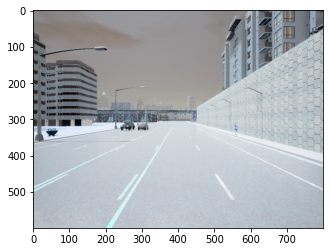

In [ ]:
plt.imshow(cv2.imread('/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/front_image/round1/round1_006476.jpg'))

# Load resnet

# Set hyperparameters

In [12]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 12  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [13]:
#identity_block
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten
from tensorflow.keras.initializers import glorot_uniform
def identity_block(X, f, filters, stage, block, time):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch_' + f'{time}'
    bn_name_base = 'bn' + str(stage) + block + '_branch_' + f'{time}'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
# input_shape = (32, 32, 3)
def ResNet50(time, input_shape, classes = 14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    # X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(input_shape)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = f'conv_{time}', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f'bn_conv_{time}')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b', time = time)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c', time = time)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b', time = time)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c', time = time)
    # X = identity_block(X, 3, [64, 64, 256], stage=3, block='d', time = time)

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b', time = time)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='d', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='e', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='f', time = time)

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b', time = time)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c', time = time)

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name=f'avg_pool_{time}')(X)
    

    # output layer
    X = Dense(512)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(128)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(64)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(32)(X) # shape = (none, 12, 17, 32)
    # X = Flatten()(X)
    
    # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # # Create model
    # model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return X

# Load ViT

In [14]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten
from tensorflow.keras.initializers import glorot_uniform

# TODO: add the config layer to each class, so they can be saved
# --> done
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Problem when loading the model: __init__() missing 1 required positional argument projection_dim
#--------------------------------------------------------
#---------UNCOMMENT THIS FOR TRAINING--------------------
#--------------------------------------------------------
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        # a = self.prj_dim
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
            'projection_dim': self.projection_dim   
            })
        return config
        
class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        images = tf.image.resize(images,size=(image_size,image_size))
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,              
            })
        return config

def ViT_feature(input, i):
    # Create patches.
    patches = Patches(patch_size)(input)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        # append_inputs.append(input)
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6,name=f'feature_layer_{i}')(encoded_patches) 
    # print(representation.shape) 
    return representation

# Create model

In [15]:
def create_resnet_on_4_sides():
    # shape = (None,50, 100, 4)
    inputs = layers.Input(shape=IMG_SHAPE)

    branch_outputs = []


    resnet_feature = ResNet50(input_shape=inputs,time=1)
    to_vit = ViT_feature(resnet_feature, '1') 
    # branch_outputs.append(to_vit)


    # stack_output = Concatenate()(branch_outputs) # shape = (None, 4, 256) which is 4 patches and 256 features
    # stack_output = Add()(branch_outputs)
    # stack_input = Concatenate()(branch_input)
    # # print(stack_output.shape)
    # dropout_output = layers.Dropout(0.5)(stack_output)
    stack_output = layers.Flatten()(to_vit)
    stack_output = layers.Dense(512)(stack_output)
    stack_output = layers.Dropout(0.2)(stack_output)
    stack_output = layers.Dense(128)(stack_output)
    stack_output = layers.Dense(64)(stack_output)
    stack_output = layers.Dense(OUTPUT)(stack_output)
    # stack_output = layers.Reshape(target_shape=(7,4))(stack_output)
    model = tf.keras.Model(inputs=inputs, outputs=stack_output)

    return model

In [15]:
resnet_model = create_resnet_on_4_sides()

In [16]:
inculded_vit = create_resnet_on_4_sides()

# Test training data

In [ ]:
x_training_test = tf.random.uniform(shape=(1200,50,100,4))
y_training_test = tf.random.uniform(shape = (1200,28,))
# test_training_dataset = tf.data.Dataset.from_tensor_slices([x_training_test,y_training_test])

x_validation_test = tf.random.uniform(shape=(200,50,100,4))
y_validation_test = tf.random.uniform(shape = (200,28,))
# test_validation_dataset = tf.data.Dataset.from_tensor_slices([x_validation_test,y_validation_test])

# Visualize result

In [ ]:
def visualize_mse_loss(history_):
    history = history_
    #  "custome mse"
    plt.plot(history.history['custom_mse_hungarian_py_func'])
    plt.plot(history.history['val_custom_mse_hungarian_py_func'])
    plt.title('model custome mse')
    plt.ylabel('custome mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def visualize_prec_recall(save_precision_075,save_precision_05,save_recall_075,save_recall_05):
    plt.figure(figsize=(8, 6), dpi=80)

    figure, axis = plt.subplots(1, 2,figsize=(10,10))

    X = np.arange(len(save_precision_075))
    # Plotting both the curves simultaneously
    # axis[0].figure(figsize=(8, 6), dpi=80)
    axis[0].plot(X, save_precision_075, color='r', label='precision 0.75')
    axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
    axis[0].set_xlabel("epochs")
    axis[0].legend()
    axis[0].set_title("Precision at threshold 0.5 and 0.75")

    # axis[1].figure(figsize=(8, 6), dpi=80)
    axis[1].plot(X, save_recall_05, color='b', label='recall 0.5')
    axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
    axis[1].set_xlabel("epochs")
    axis[1].legend()
    axis[1].set_title("Recall at threshold 0.5 and 0.75")

def visualize_3_parts_hungarian_loss(reduce_mean_cls_loss_store, regression_loss_store,reduce_confident_loss_store):
    plt.figure(figsize=(8, 6), dpi=80)

    figure, axis = plt.subplots(1, 3,figsize=(10,10))

    step = 21
    mean_regression_store = []
    mean_cls_store = []
    mean_conf_store = []
    for i in range(0,len(reduce_mean_cls_loss_store),step):
        mean_regression = tf.reduce_mean(regression_loss_store[i:i+step])
        mean_cls = tf.reduce_mean(reduce_mean_cls_loss_store[i:i+step])
        mean_conf = tf.reduce_mean(reduce_confident_loss_store[i:i+step])

        mean_regression_store.append(mean_regression)
        mean_cls_store.append(mean_cls)
        mean_conf_store.append(mean_conf)
        # print(mean_regression_store)

        X = np.arange(len(mean_regression_store))
        # Plotting both the curves simultaneously
        # axis[0].figure(figsize=(8, 6), dpi=80)
        axis[0].plot(X, mean_cls_store, color='r', label='reduce_mean_cls_loss_store')
        # axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
        axis[0].set_xlabel("value of 21 steps in each epoch in 50 epochs")
        axis[0].legend()
        axis[0].set_title("reduce_mean_cls_loss_store")

        # axis[1].figure(figsize=(8, 6), dpi=80)
        axis[1].plot(X, mean_regression_store, color='b', label='regression_loss_store')
        # axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
        axis[1].set_xlabel("value of 21 steps in each epoch in 50 epochs")
        axis[1].legend()
        axis[1].set_title("c")

        axis[2].plot(X, mean_conf_store, color='b', label='reduce_confident_loss_store')
        # axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
        axis[2].set_xlabel("value of 21 steps in each epoch in 50 epochs")
        axis[2].legend()
        axis[2].set_title("reduce_confident_loss_store")

# Built-in training

In [17]:
def run_experiment(model, history_ = None):
    optimizer_adamW = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    optimizer_adam = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    # 'mean_squared_error'
    metrics = [custom_mse_hungarian_py_func]
    model.compile(loss= hungarian_loss_fit_fixed, optimizer=optimizer_adam,
                  metrics=metrics)

    checkpoint_filepath = "/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/check_point/check_point_50_epochs"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_custom_mse_hungarian_py_func",
        save_best_only=False,
        save_weights_only=False,
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    # lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_custom_mse_hungarian_py_func', factor=0.2,
                              patience=5, min_lr=0.0001)

    
    # use recall+ precision in callback
    batch_size = 32
    myCallBack = Evaluation_callback(validation_data=validation_set.batch(batch_size))

    
    history = model.fit(
                train_set.batch(batch_size),
                validation_data=validation_set.batch(batch_size),
                epochs=60,
                verbose=1,
                shuffle=True, callbacks = [myCallBack, reduce_lr_callback] )
    
    # history_ = model.fit(x_training_test,y_training_test,batch_size=32, epochs=50, validation_split=0.2, shuffle=True )
    return history

# Run experiment

## Only resnet

### 50 epochs, optimzer adamW, not normalize input label

In [ ]:
test_data_resnet_model = run_experiment(resnet_model)

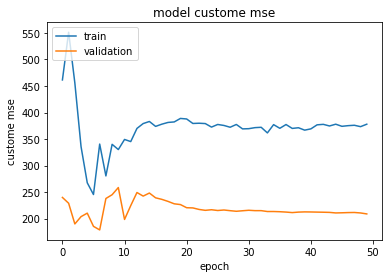

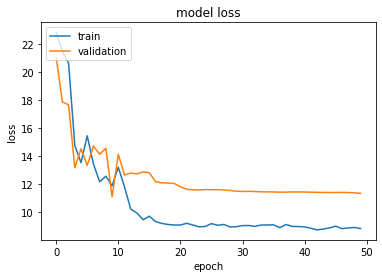

In [ ]:
history = test_data_resnet_model
#  "custome mse"
plt.plot(history.history['custom_mse_hungarian_py_func'])
plt.plot(history.history['val_custom_mse_hungarian_py_func'])
plt.title('model custome mse')
plt.ylabel('custome mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Recall at threshold 0.5 and 0.75')

<Figure size 640x480 with 0 Axes>

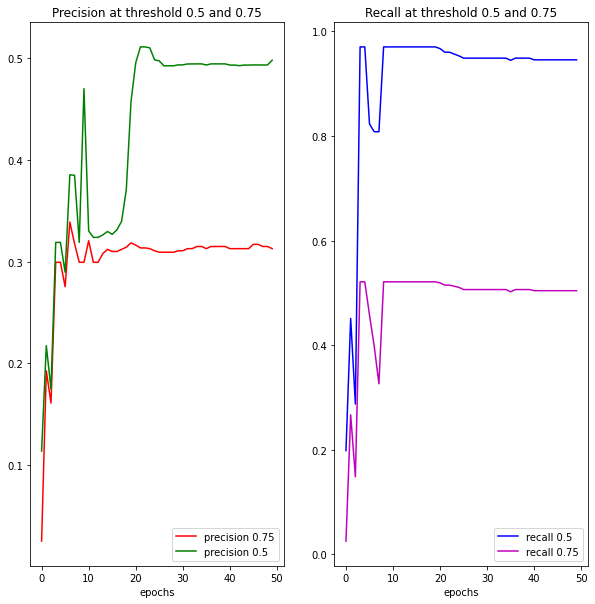

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 2,figsize=(10,10))

X = np.arange(len(save_precision_075))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, save_precision_075, color='r', label='precision 0.75')
axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("epochs")
axis[0].legend()
axis[0].set_title("Precision at threshold 0.5 and 0.75")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, save_recall_05, color='b', label='recall 0.5')
axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("epochs")
axis[1].legend()
axis[1].set_title("Recall at threshold 0.5 and 0.75")

In [ ]:
len(reduce_mean_cls_loss_store)

1450

Text(0.5, 1.0, 'reduce_confident_loss_store')

<Figure size 640x480 with 0 Axes>

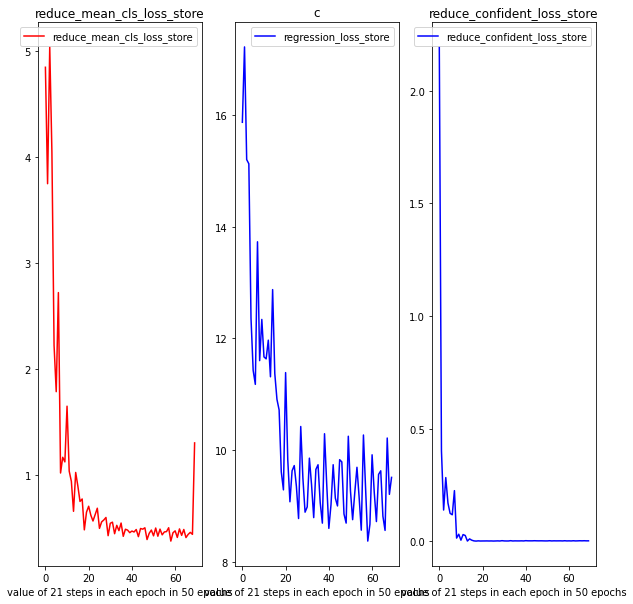

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 3,figsize=(10,10))

step = 21
mean_regression_store = []
mean_cls_store = []
mean_conf_store = []
for i in range(0,len(reduce_mean_cls_loss_store),step):
    mean_regression = tf.reduce_mean(regression_loss_store[i:i+step])
    mean_cls = tf.reduce_mean(reduce_mean_cls_loss_store[i:i+step])
    mean_conf = tf.reduce_mean(reduce_confident_loss_store[i:i+step])

    mean_regression_store.append(mean_regression)
    mean_cls_store.append(mean_cls)
    mean_conf_store.append(mean_conf)
# print(mean_regression_store)

X = np.arange(len(mean_regression_store))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, mean_cls_store, color='r', label='reduce_mean_cls_loss_store')
# axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[0].legend()
axis[0].set_title("reduce_mean_cls_loss_store")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, mean_regression_store, color='b', label='regression_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[1].legend()
axis[1].set_title("c")

axis[2].plot(X, mean_conf_store, color='b', label='reduce_confident_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[2].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[2].legend()
axis[2].set_title("reduce_confident_loss_store")

### 75 epochs. optimizer Adam, weight decay = 1e-7, not normalize input label

In [ ]:
test_data_resnet_model = run_experiment(resnet_model)

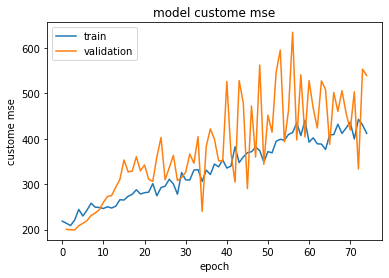

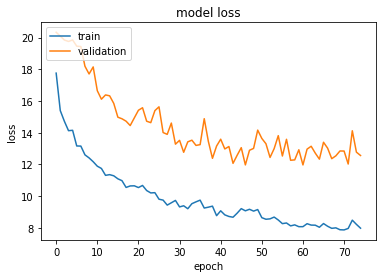

In [ ]:
history = test_data_resnet_model
#  "custome mse"
plt.plot(history.history['custom_mse_hungarian_py_func'])
plt.plot(history.history['val_custom_mse_hungarian_py_func'])
plt.title('model custome mse')
plt.ylabel('custome mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 150 epochs, optimizer Adam, weight decay = 1e-7, not normalize input

In [ ]:
test_data_resnet_model = run_experiment(resnet_model)

In [ ]:
history = test_data_resnet_model
#  "custome mse"
plt.plot(history.history['custom_mse_hungarian_py_func'])
plt.plot(history.history['val_custom_mse_hungarian_py_func'])
plt.title('model custome mse')
plt.ylabel('custome mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 2,figsize=(10,10))

X = np.arange(len(save_precision_075))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, save_precision_075, color='r', label='precision 0.75')
axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("epochs")
axis[0].legend()
axis[0].set_title("Precision at threshold 0.5 and 0.75")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, save_recall_05, color='b', label='recall 0.5')
axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("epochs")
axis[1].legend()
axis[1].set_title("Recall at threshold 0.5 and 0.75")

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 3,figsize=(10,10))

step = 21
mean_regression_store = []
mean_cls_store = []
mean_conf_store = []
for i in range(0,len(reduce_mean_cls_loss_store),step):
    mean_regression = tf.reduce_mean(regression_loss_store[i:i+step])
    mean_cls = tf.reduce_mean(reduce_mean_cls_loss_store[i:i+step])
    mean_conf = tf.reduce_mean(reduce_confident_loss_store[i:i+step])

    mean_regression_store.append(mean_regression)
    mean_cls_store.append(mean_cls)
    mean_conf_store.append(mean_conf)
# print(mean_regression_store)

X = np.arange(len(mean_regression_store))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, mean_cls_store, color='r', label='reduce_mean_cls_loss_store')
# axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[0].legend()
axis[0].set_title("reduce_mean_cls_loss_store")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, mean_regression_store, color='b', label='regression_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[1].legend()
axis[1].set_title("c")

axis[2].plot(X, mean_conf_store, color='b', label='reduce_confident_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[2].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[2].legend()
axis[2].set_title("reduce_confident_loss_store")

### 60 epochs, optimizer Adam. Normalized input labels

In [ ]:
test_data_resnet_model = run_experiment(resnet_model)

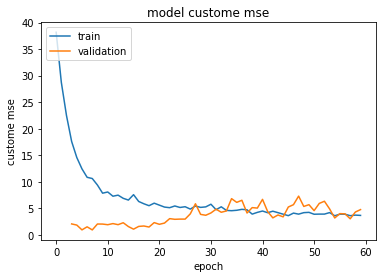

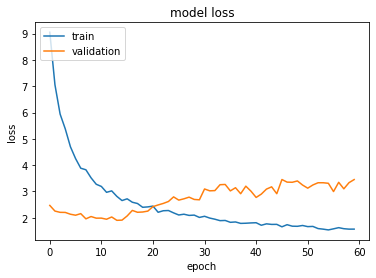

In [21]:
history = test_data_resnet_model
#  "custome mse"
plt.plot(history.history['custom_mse_hungarian_py_func'])
plt.plot(history.history['val_custom_mse_hungarian_py_func'])
plt.title('model custome mse')
plt.ylabel('custome mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Text(0.5, 1.0, 'Recall at threshold 0.5 and 0.75')

<Figure size 640x480 with 0 Axes>

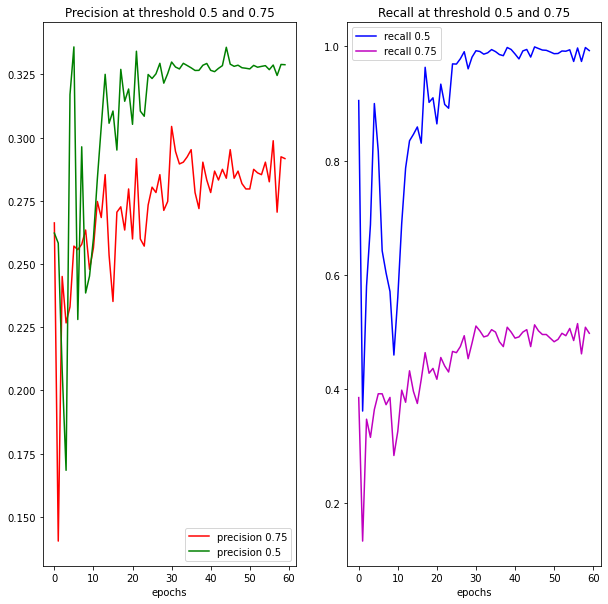

In [22]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 2,figsize=(10,10))

X = np.arange(len(save_precision_075))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, save_precision_075, color='r', label='precision 0.75')
axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("epochs")
axis[0].legend()
axis[0].set_title("Precision at threshold 0.5 and 0.75")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, save_recall_05, color='b', label='recall 0.5')
axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("epochs")
axis[1].legend()
axis[1].set_title("Recall at threshold 0.5 and 0.75")

Text(0.5, 1.0, 'reduce_confident_loss_store')

<Figure size 640x480 with 0 Axes>

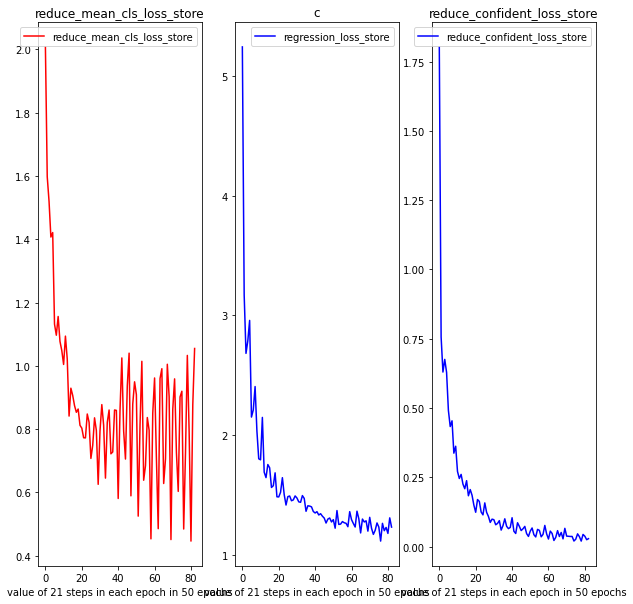

In [23]:
plt.figure(figsize=(8, 6), dpi=80)

figure, axis = plt.subplots(1, 3,figsize=(10,10))

step = 21
mean_regression_store = []
mean_cls_store = []
mean_conf_store = []
for i in range(0,len(reduce_mean_cls_loss_store),step):
    mean_regression = tf.reduce_mean(regression_loss_store[i:i+step])
    mean_cls = tf.reduce_mean(reduce_mean_cls_loss_store[i:i+step])
    mean_conf = tf.reduce_mean(reduce_confident_loss_store[i:i+step])

    mean_regression_store.append(mean_regression)
    mean_cls_store.append(mean_cls)
    mean_conf_store.append(mean_conf)
# print(mean_regression_store)

X = np.arange(len(mean_regression_store))
# Plotting both the curves simultaneously
# axis[0].figure(figsize=(8, 6), dpi=80)
axis[0].plot(X, mean_cls_store, color='r', label='reduce_mean_cls_loss_store')
# axis[0].plot(X, save_precision_05, color='g', label='precision 0.5')
axis[0].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[0].legend()
axis[0].set_title("reduce_mean_cls_loss_store")

# axis[1].figure(figsize=(8, 6), dpi=80)
axis[1].plot(X, mean_regression_store, color='b', label='regression_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[1].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[1].legend()
axis[1].set_title("c")

axis[2].plot(X, mean_conf_store, color='b', label='reduce_confident_loss_store')
# axis[1].plot(X, save_recall_075, color='m', label='recall 0.75')
axis[2].set_xlabel("value of 21 steps in each epoch in 50 epochs")
axis[2].legend()
axis[2].set_title("reduce_confident_loss_store")

## Model includes ViT

### 50 epochs, optimizer Adam, weight decay = 1e-6, normalized input

In [ ]:
test_data_resnet_model = run_experiment(inculded_vit)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
      3/Unknown - 77s 19s/step - loss: 3.5555 - custom_mse_hungarian_py_func: 2.8853Can not convert <class 'str'> to int
056406 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056406 (1).jpg
Can not convert <class 'str'> to int
056408 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056408 (1).jpg
Can not convert <class 'str'> to int
056410 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056410 (1).jpg
Can not convert <class 'str'> to int
056412 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056412 (1).jpg
Can not convert <class 'str'> to int
056414 (1)     /content/drive/Shareddrives/Behavior vehicles pre

In [3]:
visualize_mse_loss(test_data_resnet_model)

NameError: ignored

In [ ]:
visualize_prec_recall(save_precision_075,save_precision_05,save_recall_075,save_recall_05)

NameError: ignored

In [2]:
visualize_3_parts_hungarian_loss(reduce_mean_cls_loss_store, regression_loss_store,reduce_confident_loss_store)

NameError: ignored